Image classification<br/>
[Kaggle dataset link](https://www.kaggle.com/khanrahim/hackereath-holiday-season-deep-learning-contest)<br>91% accuracy on validation

In [ ]:
# Unpack data
# Download and unpack zip archive to data folder
# !unzip [LINK_TO_ZIP]/14feeca248c811eb.zip -d /data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
import shutil
from tqdm import tqdm
from os import listdir
import os
import matplotlib.image as mpimg

In [ ]:
TRAIN_FOLDER = r'/data/train/'
TO_PREDICT_FOLDER = r'/data/test/'
BATCH_SIZE = 100
IMG_SIZE = (224, 224)

In [ ]:
df_imgs = pd.read_csv('/data/train.csv')

In [ ]:
df_imgs.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


Lets's taka a look at classes distribution

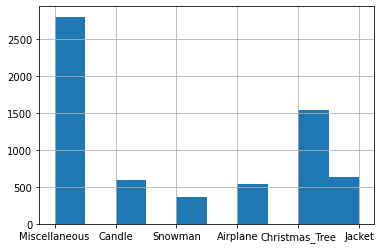

In [ ]:
df_imgs['Class'].hist()

Others and christmas trees have most of the data

Code below prepares data for tensorflow standart modules use. It takes all images and moves them according to their class in dataframe

In [ ]:
# Create data structure for tensorflow
# Need to be done once

# for class_name in df_imgs.Class.unique():
#   Path(TRAIN_FOLDER + class_name).mkdir(parents=True, exist_ok=True)

# for index, row in tqdm(df_imgs.iterrows(), total=df_imgs.shape[0]):
#   shutil.move(TRAIN_FOLDER + row['Image'], TRAIN_FOLDER + row['Class'] + '/' + row['Image'])

Gathering size information to choose best image dimensions

In [ ]:
# Gather info of img sizes
# You need it once. Then use pic_sizes.csv

# img_sizes = []
# for folder in listdir(TRAIN_FOLDER):
#   print(folder)
#   for filename in tqdm(listdir(TRAIN_FOLDER + folder + '/')):
#     image = Image.open(TRAIN_FOLDER + folder + '/' + filename)
#     width, height = image.size
#     img_sizes.append([width, height])
# df = pd.DataFrame(img_sizes, columns =['width', 'height'])
# df.to_csv('/data/pic_sizes.csv')

In [ ]:
df_img_sizes = pd.read_csv('/data/pic_sizes.csv')

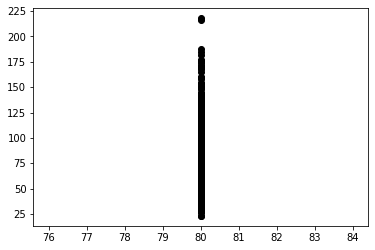

In [ ]:
plt.plot(df_img_sizes['width'], df_img_sizes['height'], 'o', color='black');

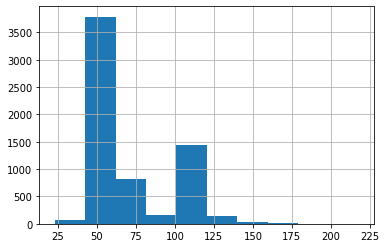

In [ ]:
df_img_sizes['height'].hist()

As we see on pics above, all images share same width = 80 px and vary in height from 25 to 224 px. I choose (224×224)

Start learning. Import data to TF tensors

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_FOLDER,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size = BATCH_SIZE,
  image_size = IMG_SIZE)

Found 6469 files belonging to 6 classes.
Using 5176 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_FOLDER,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size = BATCH_SIZE,
  image_size = IMG_SIZE)

Found 6469 files belonging to 6 classes.
Using 1293 files for validation.


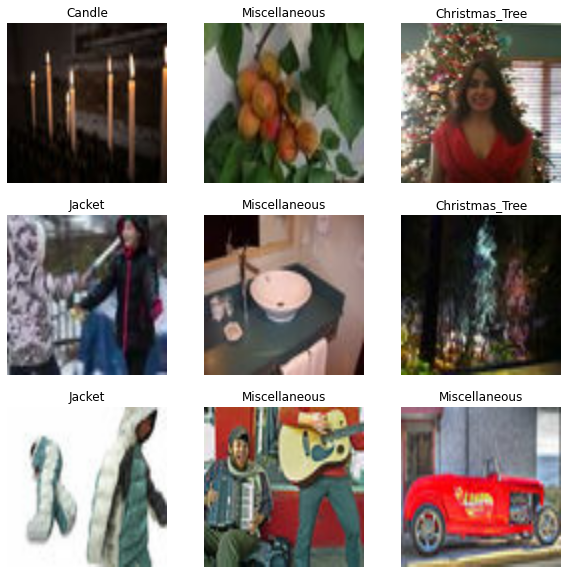

In [ ]:
# Check if everything is fine
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Add image augmentation layers to solve overfitting problem

In [ ]:
# Image augmentation to solve overfitting and get better results

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
])

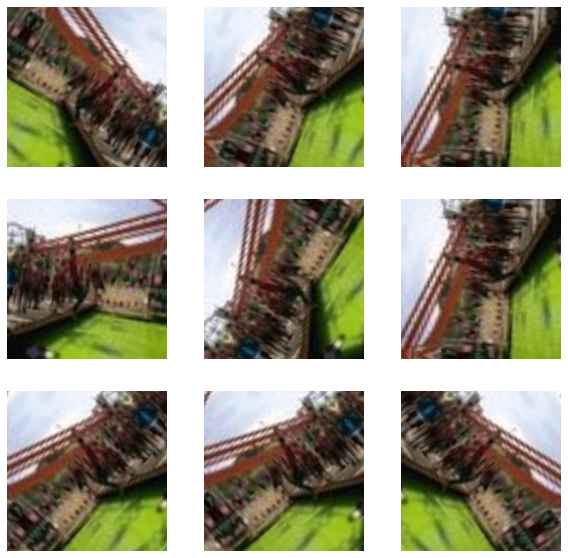

In [ ]:
# Check augmentation
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


Preparing layers for input into models

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

I've tried few models, such as ResNet, MobileNet, VGG.<br>ResNet turned to be the best option

In [ ]:
# Uing MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [ ]:
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
checkpoint_path = '/data/model_checkpoint/resnet_c.h5'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1, 
                                                 monitor='val_accuracy',
                                                 save_best_only=True)


In [ ]:
base_learning_rate = 0.0001
# Initiate model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.load_weights(checkpoint_path)

In [ ]:
# Load model
# model = tf.keras.models.load_model(checkpoint_path)

In [ ]:
# Change learning rate if needed

# tf.keras.backend.set_value(
#     model.optimizer.learning_rate,
#     0.00001
# )


In [ ]:
EPOCHS = 100

In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[cp_callback])


In [ ]:
# Let's fine tune model and train few top layers
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


I've added fine tuning by unfreezing some last layers and fit them for better prediction. Which resulted in +2pp in validation accuracy from completely frozen model

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
checkpoint_path_ft = '/data/model_checkpoint/resnet_finetuned_c.h5'

cp_callback_ft = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_ft,
                                                 save_weights_only=False,
                                                 verbose=1, 
                                                 monitor='val_accuracy',
                                                 save_best_only=True)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
TOTAL_EPOCHS = EPOCHS + 100

In [ ]:
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[cp_callback_ft])


Epoch 100/200
52/52 [==============================] - 23s 412ms/step - loss: 0.3295 - accuracy: 0.8738 - val_loss: 0.2973 - val_accuracy: 0.8925

Epoch 00100: val_accuracy improved from -inf to 0.89250, saving model to /content/drive/MyDrive/hackathons/holiday_image/model_checkpoint/resnet_finetuned_c.h5
Epoch 101/200
52/52 [==============================] - 22s 392ms/step - loss: 0.2503 - accuracy: 0.9123 - val_loss: 0.2807 - val_accuracy: 0.9064

Epoch 00101: val_accuracy improved from 0.89250 to 0.90642, saving model to /content/drive/MyDrive/hackathons/holiday_image/model_checkpoint/resnet_finetuned_c.h5
Epoch 102/200
52/52 [==============================] - 22s 392ms/step - loss: 0.2065 - accuracy: 0.9231 - val_loss: 0.2754 - val_accuracy: 0.9080

Epoch 00102: val_accuracy improved from 0.90642 to 0.90797, saving model to /content/drive/MyDrive/hackathons/holiday_image/model_checkpoint/resnet_finetuned_c.h5
Epoch 103/200
52/52 [==============================] - 22s 392ms/step - l

Completely frozen model predicts faster

In [ ]:
model.trainable = False

In [ ]:
def decode_img(file_path, img_height, img_width):
  img = tf.io.read_file(file_path)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


In [ ]:
img_names = []
class_names_list = []

for filename in tqdm(listdir(TO_PREDICT_FOLDER)):
  link = TO_PREDICT_FOLDER + filename
  i = np.argmax(model.predict(decode_img(link, IMG_SIZE[0], IMG_SIZE[1])[None,:,:,:]))
  class_names_list.append(class_names[i])
  img_names.append(filename)

100%|██████████| 3489/3489 [02:51<00:00, 20.37it/s]


In [ ]:
df_result = pd.DataFrame(zip(img_names, class_names_list), columns = ['Image', 'Class'])

In [ ]:
list_to_show = np.random.randint(low=0, high = df_result.shape[0], size=9)

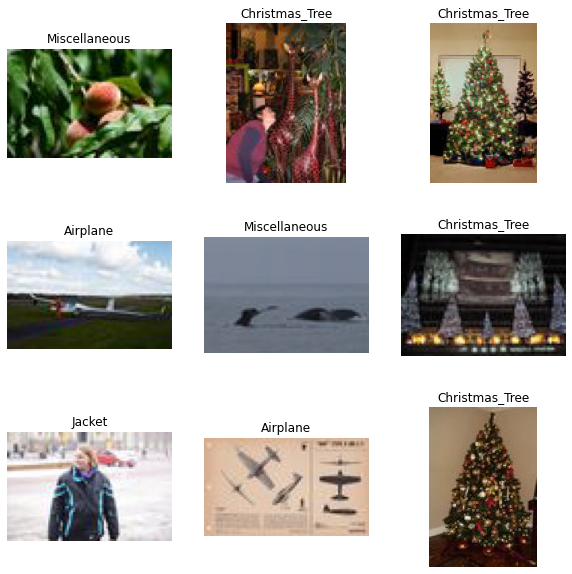

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
  ax = fig.add_subplot(3, 3, i + 1)
  plt.imshow(mpimg.imread(TO_PREDICT_FOLDER + df_result.iloc[[list_to_show[i-1]]]['Image'].item()))
  plt.title(df_result.iloc[[list_to_show[i-1]]]['Class'].item())
  plt.axis("off")

In [ ]:
df_result.to_csv('/data/results/test_v3.csv', index=False)